## Long-Term Climatology of Ozone in Houston, Texas

According to the 2019 American Lung Association "State of the Air" report [(American Lung Association, 2019)](http://www.stateoftheair.org/assets/sota-2019-full.pdf), Houston is ranked $9^{th}$ among 25 cities with the worst ozone pollution. This pollution is mainly contributed by heavily populated plants of chemical, petrochemical, and oil and gas industries around the city [(Ge et al., 2017)](https://reader.elsevier.com/reader/sd/pii/S1352231017303515?token=44E63D786CC0CC16CAAAA5F75D5C81E1BD48140CC266B7A4EFF0082714DD578B6D2D5869C15AB8F62CE2B5CCD1F364B7). Produced by the photochemical reactions of primary pollutants like volcatile organic compounds (VOCs) and nitrogen oxides (NOx), tropospheric ozone causes serious health problems, including shortness of breath, wheezing and coughing, asthma attacks, increased risk of respiratory infections, and increased susceptibility to pulmonary inflammation ([American Lung Association, 2019](http://www.stateoftheair.org/assets/sota-2019-full.pdf); [Ge et al., 2018](https://www.sciencedirect.com/science/article/pii/S0269749118316531?casa_token=csGab9rT0t0AAAAA:xfZtZ1xzryCb1F661t6jexRuSZhMK20XSiQfV2G44KoUmwFTVbRU41YdzlnuccnK3BjaLMJZ9A)). This notebook presents the long-term climatology study of ozone in the City of Houston from January 2005 to December 2019 by utilizing different statistical analysis methods on the hourly data from the spring and summer seasons acquired through part one notebook.

### Required packages

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import folium
import calendar
import datetime
import matplotlib.cbook as cbook
from scipy import stats
import pytz 
from IPython.display import IFrame

### Houston, Texas Site

| State | County | City | State Code | Count Code | Site Number | Longitude | Latitude | Elevation (m) | Land Use | Location Setting
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Texas | Harris | Houston | 48 | 201 | 24 | -95.326137 | 29.901036 | 24.1 | Residential | Suburban

In [2]:
my_map = folium.Map(location=[29.901036, -95.326137],tiles='Stamen Terrain', zoom_start=10)

location = [29.901036, -95.326137]
folium.Marker(location, popup='Houston Site, Texas',icon=folium.Icon(color='red',icon_color='white',icon='dot-circle-o',angle=0, prefix='fa')).add_to(my_map)
#my_map

In [3]:
my_map.save('./data/Houston.html')

In [4]:
IFrame('./data/Houston.html', width=900, height=600)

### Reading the CSV file as pandas dataframe

In [5]:
# Reading the file
filename = sorted(list(Path("./data").glob("Houston.csv")))

# Extracting the possible decoding of the file
with open(filename[0], 'rb') as f:
    result = chardet.detect(f.read()) 
print('Encoding of the CSV file:', result['encoding'])

df = pd.read_csv(filename[0],skiprows=0,usecols=['ozone_ppm','Date Time GMT'],encoding = result['encoding'],parse_dates=['Date Time GMT'])
df = df[['Date Time GMT','ozone_ppm']]

Encoding of the CSV file: UTF-8-SIG


### Localize to central standard time and central daylight time from GMT

In [6]:
df.insert(loc=0,column='Date Time Loc',value=df['Date Time GMT'].dt.tz_localize('GMT').dt.tz_convert('US/Central'))
df_local = df.drop(['Date Time GMT'], axis=1)
df_local['Date Time Loc'] = df_local['Date Time Loc'].dt.tz_localize(tz=None)

### Compute time series of daily (a) mean and (b) maximum ozone levels and plot the results

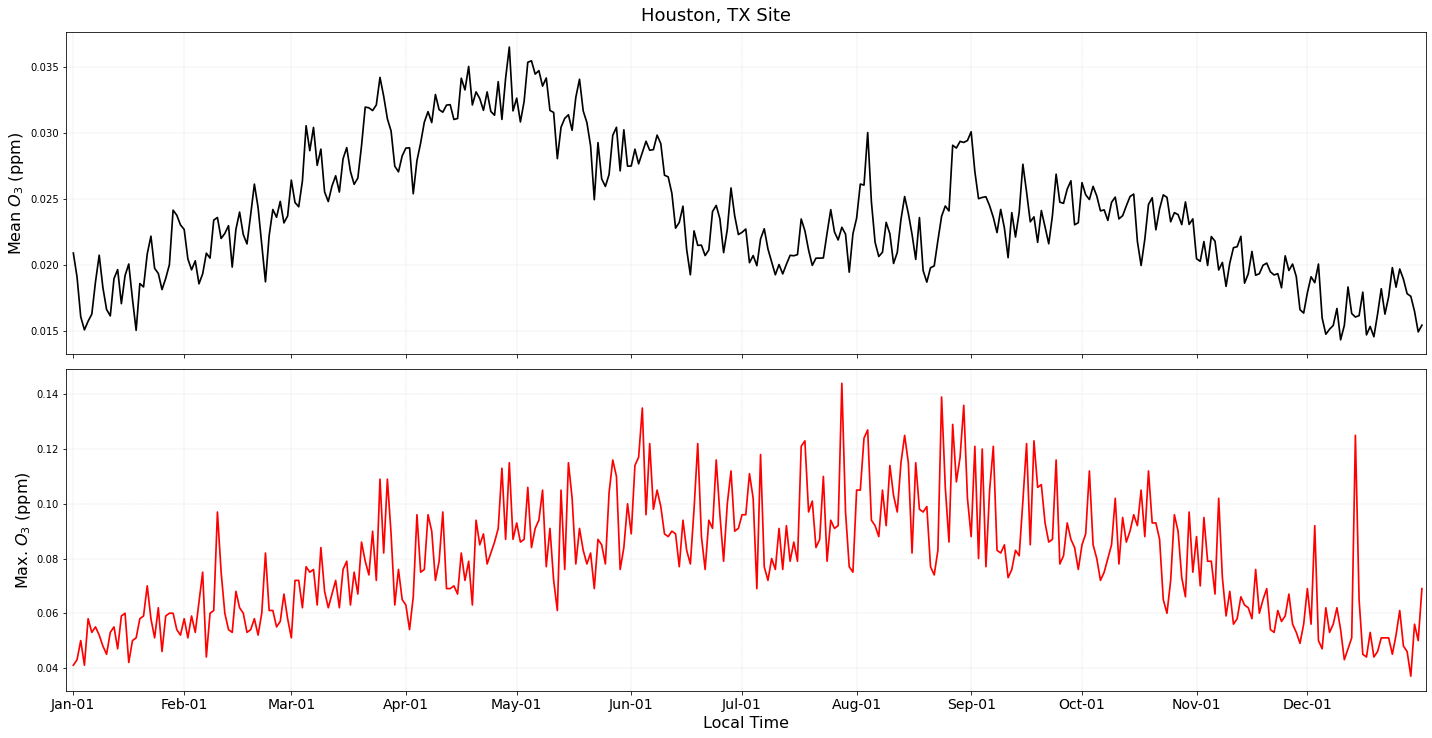

In [7]:
# Aggregate to daily based on mean and max
df_daily_mean = df_local.groupby(pd.Grouper(key='Date Time Loc', freq='D')).mean().reset_index()
df_daily_max = df_local.groupby(pd.Grouper(key='Date Time Loc', freq='D')).max().reset_index()

# Aggregate by month and day 

#Mean
df_daily_mean_mod = df_daily_mean.set_index('Date Time Loc')
df_daily_mean_mod.index.name = None
df_daily_mean_grouped = df_daily_mean_mod.groupby([df_daily_mean_mod.index.month, df_daily_mean_mod.index.day]).mean()

#Max
df_daily_max_mod = df_daily_max.set_index('Date Time Loc')
df_daily_max_mod.index.name = None
df_daily_max_grouped = df_daily_max_mod.groupby([df_daily_max_mod.index.month, df_daily_max_mod.index.day]).max()


#Plotting figures
df_daily_mean_grouped_mod = df_daily_mean_grouped
df_daily_mean_grouped_mod.index = df_daily_mean_grouped_mod.index.get_level_values(0)
df_daily_mean_grouped_mod_np = df_daily_mean_grouped_mod.index.astype(int).to_numpy()

(unique, counts) = np.unique(df_daily_mean_grouped_mod_np, return_counts=True)
frequencies = np.asarray((unique, counts)).T

month = frequencies[:,0]
month_text = [calendar.month_abbr[x] for x in month]
month_day_text = [s + '-01' for s in month_text]

counts_days = frequencies[:,1]
counts_days_cumsum = (np.cumsum(counts_days) - 1)[:11]
counts_days_cumsum_mod = np.insert(counts_days_cumsum, 0, 0)

fig, ax = plt.subplots(2, 1,figsize=(20,10))
ax[0].plot(df_daily_mean_grouped.to_numpy(),linewidth=1.7,color='black')
ax[0].set_xlim(-2, 366)
ax[0].set_xticks(counts_days_cumsum_mod)
ax[0].set_xticklabels([])
ax[0].set_ylabel('Mean $O_3$ (ppm)',fontsize=16)
ax[0].grid(linestyle='--', linewidth=0.2)

ax[1].plot(df_daily_max_grouped.to_numpy(),linewidth=1.7,color='red')
ax[1].set_xlim(-2, 366)
ax[1].set_xticks(counts_days_cumsum_mod)
ax[1].set_xticklabels(month_day_text,fontsize=14)
ax[1].set_ylabel('Max. $O_3$ (ppm)',fontsize=16)
ax[1].set_xlabel('Local Time',fontsize=16)
ax[1].grid(linestyle='--', linewidth=0.2)

plt.suptitle('Houston, TX Site',y=1.02, fontsize=18)
plt.tight_layout()
plt.savefig('./output/fig_01_long_term_time_series.png',dpi=100,bbox_inches='tight')
plt.show()

### Hourly MAM and JJA Average and Standard Deviation

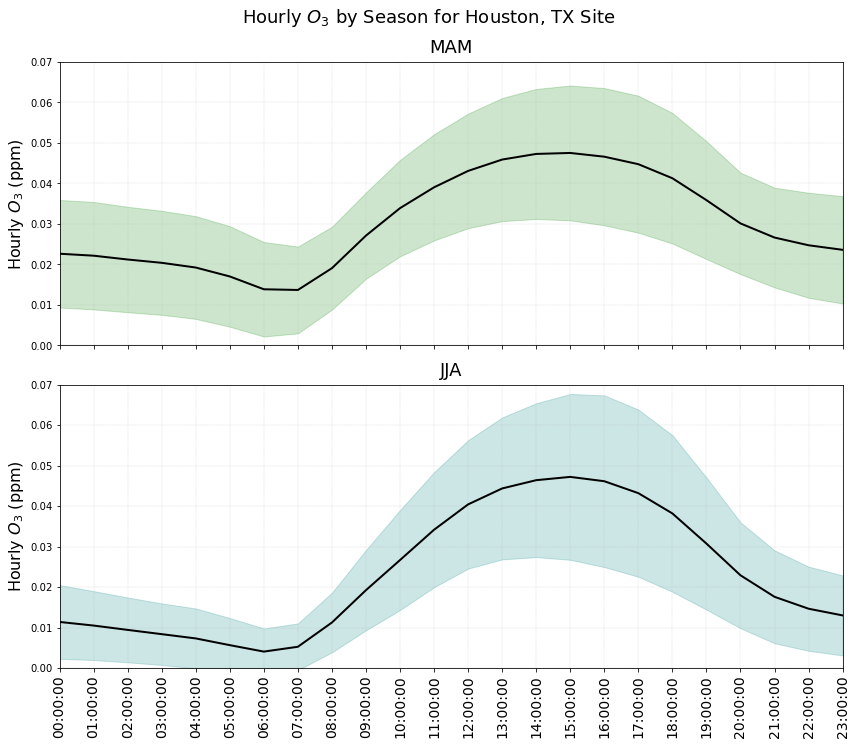

In [8]:
### Selecting rows with months of March, April, and May, that represents Spring season
df_mam = (df_local[(df_local['Date Time Loc'].dt.month == 3) | (df_local['Date Time Loc'].dt.month == 4)\
                  | (df_local['Date Time Loc'].dt.month == 5)]).reset_index(drop=True)

### Selecting rows with months of June, July, and August, that represents Summer season
df_jja = (df_local[(df_local['Date Time Loc'].dt.month == 6) | (df_local['Date Time Loc'].dt.month == 7)\
                  | (df_local['Date Time Loc'].dt.month == 8)]).reset_index(drop=True)


### Setting the data and time as index
df_mam_mod = df_mam.set_index('Date Time Loc')
df_mam_mod.index.name = None

df_jja_mod = df_jja.set_index('Date Time Loc')
df_jja_mod.index.name = None

### Calculating mean and standard deviation
df_mam_mean = df_mam_mod.groupby(df_mam_mod.index.hour).mean()
df_mam_std = df_mam_mod.groupby(df_mam_mod.index.hour).std()

df_jja_mean = df_jja_mod.groupby(df_jja_mod.index.hour).mean()
df_jja_std = df_jja_mod.groupby(df_jja_mod.index.hour).std()

### Plotting figures
df_mam_hhmmss = df_mam
df_mam['hhmmss'] = df_mam_hhmmss['Date Time Loc'].dt.time
df_mam_hhmmss['hhmmss'] = df_mam_hhmmss['hhmmss'].astype(str)
df_mam_hhmmss_unique = sorted(df_mam_hhmmss['hhmmss'].unique())

data_plt_mean = pd.DataFrame({"x":np.arange(24), "y_mam":df_mam_mean.to_numpy().reshape((24, )),"y_jja":df_jja_mean.to_numpy().reshape((24, ))})
data_plt_std = pd.DataFrame({"x":np.arange(24),"std_mam":df_mam_std.to_numpy().reshape((24, )),"std_jja":df_jja_std.to_numpy().reshape((24, ))})

fig, axs = plt.subplots(2, 1,figsize=(12,10))

axs = axs.ravel()

for i in range(2):
    axs[i].plot(data_plt_mean.iloc[:,i+1],'k',linewidth=2)
    
    axs[i].set_xlim(0, 23)
    axs[i].set_ylim(0, 0.07)
    axs[i].set_ylabel('Hourly $O_3$ (ppm)',fontsize=16)
    axs[i].set_xticks(np.arange(24))
    axs[i].grid(linestyle='--', linewidth=0.2)
    
    if i == 0:
        col = 'green'
        axs[i].set_xticklabels([])
        axs[i].set_title('MAM',y=1.01, fontsize=18)
    elif i == 1:
        col = 'teal'
        axs[i].set_xticklabels(df_mam_hhmmss_unique,rotation = 90,fontsize=14) 
        axs[i].set_title('JJA',y=1.01, fontsize=18)
        
    axs[i].fill_between(data_plt_mean["x"], y1=data_plt_mean.iloc[:,i+1] - data_plt_std.iloc[:,i+1],\
                       y2=data_plt_mean.iloc[:,i+1] + data_plt_std.iloc[:,i+1],color=col,alpha=.2)    

plt.suptitle('Hourly $O_3$ by Season for Houston, TX Site',y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('./output/fig_02_mam_jja_hourly_average.png',dpi=100,bbox_inches='tight')
plt.show()

### MAM and JJA  Hourly Average and Standard Deviation by weekdays and weekends

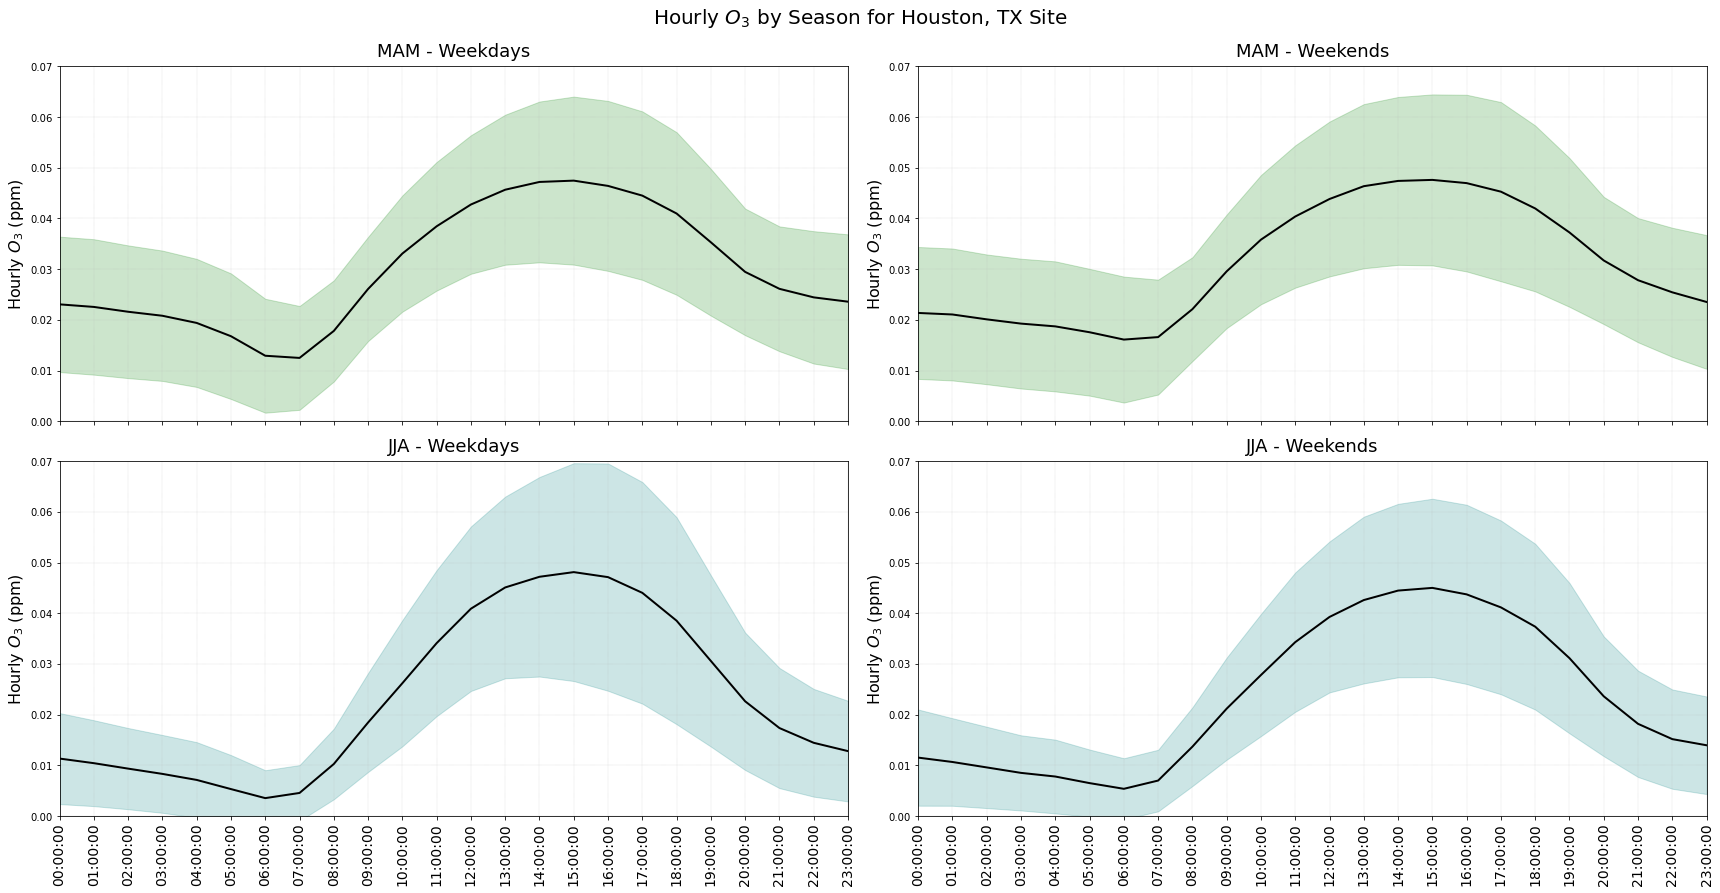

In [9]:
### Extract day number in which the week starts in Monday denoted by 0 and ends on Sunday which is denoted by 6
df_mam_weeks = df_mam
df_mam_weeks['daynum'] = df_mam_weeks['Date Time Loc'].dt.dayofweek

df_jja_weeks = df_jja
df_jja_weeks['daynum'] = df_jja_weeks['Date Time Loc'].dt.dayofweek

df_mam_weekday = df_mam_weeks[(df_mam_weeks['daynum'] >= 0) & (df_mam_weeks['daynum'] <= 4)].drop(columns=['daynum'])
df_mam_weekend = df_mam_weeks[(df_mam_weeks['daynum'] >= 5) & (df_mam_weeks['daynum'] <= 6)].drop(columns=['daynum'])

df_jja_weekday = df_jja_weeks[(df_jja_weeks['daynum'] >= 0) & (df_jja_weeks['daynum'] <= 4)].drop(columns=['daynum'])
df_jja_weekend = df_jja_weeks[(df_jja_weeks['daynum'] >= 5) & (df_jja_weeks['daynum'] <= 6)].drop(columns=['daynum'])

# Weekdays
df_mam_weekday_mod = df_mam_weekday.set_index('Date Time Loc')
df_mam_weekday_mod.index.name = None

df_jja_weekday_mod = df_jja_weekday.set_index('Date Time Loc')
df_jja_weekday_mod.index.name = None

hourly_mean_mam_wd = df_mam_weekday_mod.groupby(df_mam_weekday_mod.index.hour).mean()
hourly_std_mam_wd = df_mam_weekday_mod.groupby(df_mam_weekday_mod.index.hour).std()

hourly_mean_jja_wd = df_jja_weekday_mod.groupby(df_jja_weekday_mod.index.hour).mean()
hourly_std_jja_wd = df_jja_weekday_mod.groupby(df_jja_weekday_mod.index.hour).std()

# Weekends
df_mam_weekend_mod = df_mam_weekend.set_index('Date Time Loc')
df_mam_weekend_mod.index.name = None

df_jja_weekend_mod = df_jja_weekend.set_index('Date Time Loc')
df_jja_weekend_mod.index.name = None

hourly_mean_mam_we = df_mam_weekend_mod.groupby(df_mam_weekend_mod.index.hour).mean()
hourly_std_mam_we = df_mam_weekend_mod.groupby(df_mam_weekend_mod.index.hour).std()

hourly_mean_jja_we = df_jja_weekend_mod.groupby(df_jja_weekend_mod.index.hour).mean()
hourly_std_jja_we = df_jja_weekend_mod.groupby(df_jja_weekend_mod.index.hour).std()

data_plt_mean_wd_we = pd.DataFrame({"x":np.arange(24), "y_mam_wd":hourly_mean_mam_wd.to_numpy().reshape((24, )),"y_mam_we":hourly_mean_mam_we.to_numpy().reshape((24, )),\
                                    "y_jja_wd":hourly_mean_jja_wd.to_numpy().reshape((24, )),"y_jja_we":hourly_mean_jja_we.to_numpy().reshape((24, ))})
data_plt_std_wd_we = pd.DataFrame({"x":np.arange(24), "std_mam_wd":hourly_std_mam_wd.to_numpy().reshape((24, )),"std_mam_we":hourly_std_mam_we.to_numpy().reshape((24, )),\
                                  "std_jja_wd":hourly_std_jja_wd.to_numpy().reshape((24, )),"std_jja_we":hourly_std_jja_we.to_numpy().reshape((24, ))})

### Generating figures
fig, axs = plt.subplots(2, 2,figsize=(24,12))
axs = axs.ravel()

for i in range(4):
    axs[i].plot(data_plt_mean_wd_we.iloc[:,i+1],'k',linewidth=2)
    
    axs[i].set_xlim(0, 23)
    axs[i].set_ylim(0, 0.07)
    axs[i].set_ylabel('Hourly $O_3$ (ppm)',fontsize=16)
    axs[i].set_xticks(np.arange(24))
    axs[i].grid(linestyle='--', linewidth=0.2)
    
    if i == 0 or i == 1:
        col = 'green'
        axs[i].set_xticklabels([])
    elif i == 2 or i == 3:
        col = 'teal'
        axs[i].set_xticklabels(df_mam_hhmmss_unique,rotation = 90,fontsize=14)

    axs[i].fill_between(data_plt_std_wd_we["x"], y1=data_plt_mean_wd_we.iloc[:,i+1] - data_plt_std_wd_we.iloc[:,i+1],\
                       y2=data_plt_mean_wd_we.iloc[:,i+1] + data_plt_std_wd_we.iloc[:,i+1],color=col,alpha=.2)
    
axs[0].set_title('MAM - Weekdays',y=1.01, fontsize=18)
axs[1].set_title('MAM - Weekends',y=1.01, fontsize=18) 
axs[2].set_title('JJA - Weekdays',y=1.01, fontsize=18)
axs[3].set_title('JJA - Weekends',y=1.01, fontsize=18) 

plt.suptitle('Hourly $O_3$ by Season for Houston, TX Site',y=1.03, fontsize=20)
plt.tight_layout()
plt.savefig('./output/fig_03_mam_jja_hourly_ozone_weekdays_weekends.png',dpi=100,bbox_inches='tight')
plt.show()

### Long-term monthly climatology of ozone

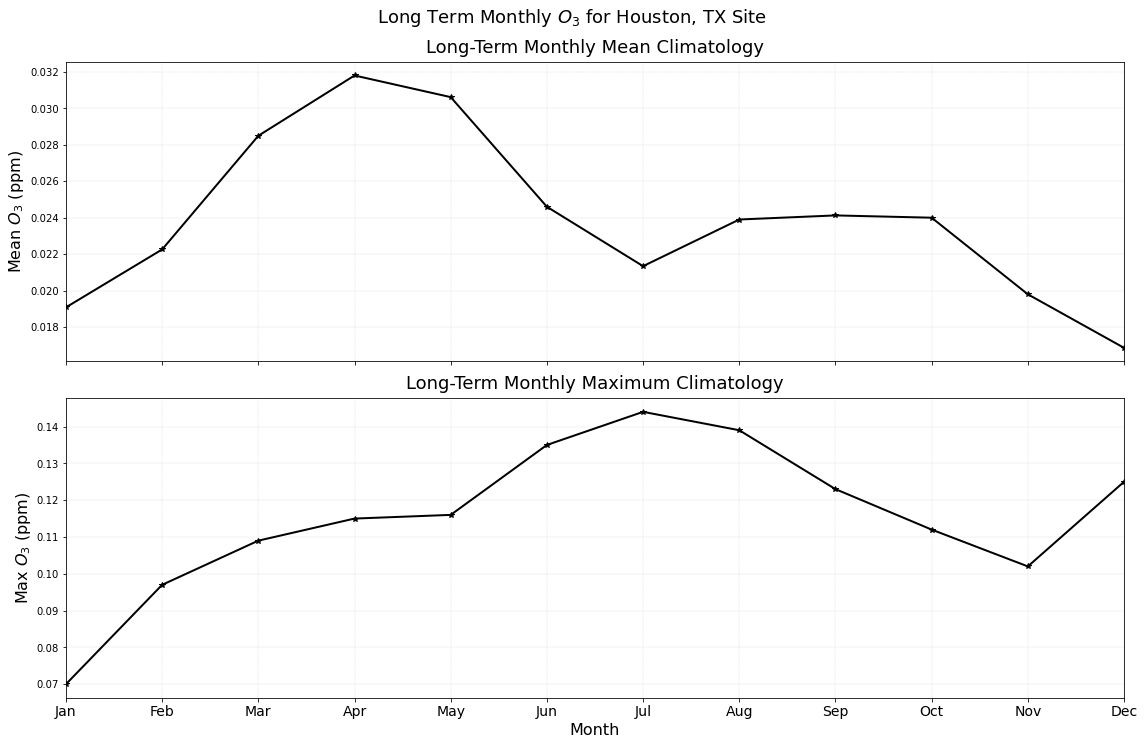

In [10]:
df_month = df_local

df_month_agg_mean = df_month.groupby(df_month['Date Time Loc'].dt.strftime('%b'))['ozone_ppm'].mean().reset_index()
df_month_agg_max = df_month.groupby(df_month['Date Time Loc'].dt.strftime('%b'))['ozone_ppm'].max().reset_index()
df_month_agg_std = df_month.groupby(df_month['Date Time Loc'].dt.strftime('%b'))['ozone_ppm'].std().reset_index()

df_month_agg_mean['month_num'] = ([(datetime.datetime.strptime(month_name, "%b")).month for month_name in df_month_agg_mean['Date Time Loc']])
df_month_agg_mean_sorted = df_month_agg_mean.sort_values(by=['month_num'])
month_list = df_month_agg_mean_sorted['Date Time Loc'].tolist()

df_month_agg_max['month_num'] = ([(datetime.datetime.strptime(month_name, "%b")).month for month_name in df_month_agg_max['Date Time Loc']])
df_month_agg_max_sorted = df_month_agg_max.sort_values(by=['month_num'])

df_month_agg_std['month_num'] = ([(datetime.datetime.strptime(month_name, "%b")).month for month_name in df_month_agg_std['Date Time Loc']])
df_month_agg_std_sorted = df_month_agg_std.sort_values(by=['month_num'])

data_plot_month = pd.DataFrame({"x":np.arange(12), "y":df_month_agg_mean_sorted['ozone_ppm'].to_numpy().reshape((12, )),\
                             "std":df_month_agg_std_sorted['ozone_ppm'].to_numpy().reshape((12, ))})


## Plotting figure
fig, ax = plt.subplots(2, 1,figsize=(16,10))
## Mean
ax[0].plot(df_month_agg_mean_sorted['ozone_ppm'].to_numpy(),'k-*',linewidth=2)
#ax[0].fill_between(data_plot_month["x"], y1=data_plot_month["y"] - data_plot_month["std"], y2=data_plot_month["y"] + data_plot_month["std"], alpha=.2)
ax[0].set_xlim(0, 11)
ax[0].set_xticks(np.arange(12))
ax[0].set_xticklabels([])
ax[0].set_ylabel('Mean $O_3$ (ppm)',fontsize=16)
ax[0].set_title('Long-Term Monthly Mean Climatology',y=1.01, fontsize=18)
ax[0].grid(linestyle='--', linewidth=0.2)

## Max
ax[1].plot(df_month_agg_max_sorted['ozone_ppm'].to_numpy(),'k-*',linewidth=2)
ax[1].set_xlim(0, 11)
ax[1].set_xticks(np.arange(12))
ax[1].set_xticklabels(month_list,rotation = 0,fontsize=14)
ax[1].set_ylabel('Max $O_3$ (ppm)',fontsize=16)
ax[1].set_xlabel('Month',fontsize=16)
ax[1].set_title('Long-Term Monthly Maximum Climatology',y=1.01, fontsize=18)
ax[1].grid(linestyle='--', linewidth=0.2)

plt.suptitle('Long Term Monthly $O_3$ for Houston, TX Site',y=1.03, fontsize=18)
plt.tight_layout()
plt.savefig('./output/fig_04_long_term_monthly.png',dpi=100,bbox_inches='tight')
plt.show()

### Composite yearly average for MAM and JJA

In [11]:
df_mam_year = df_mam.iloc[:,0:2]
df_jja_year = df_jja.iloc[:,0:2]

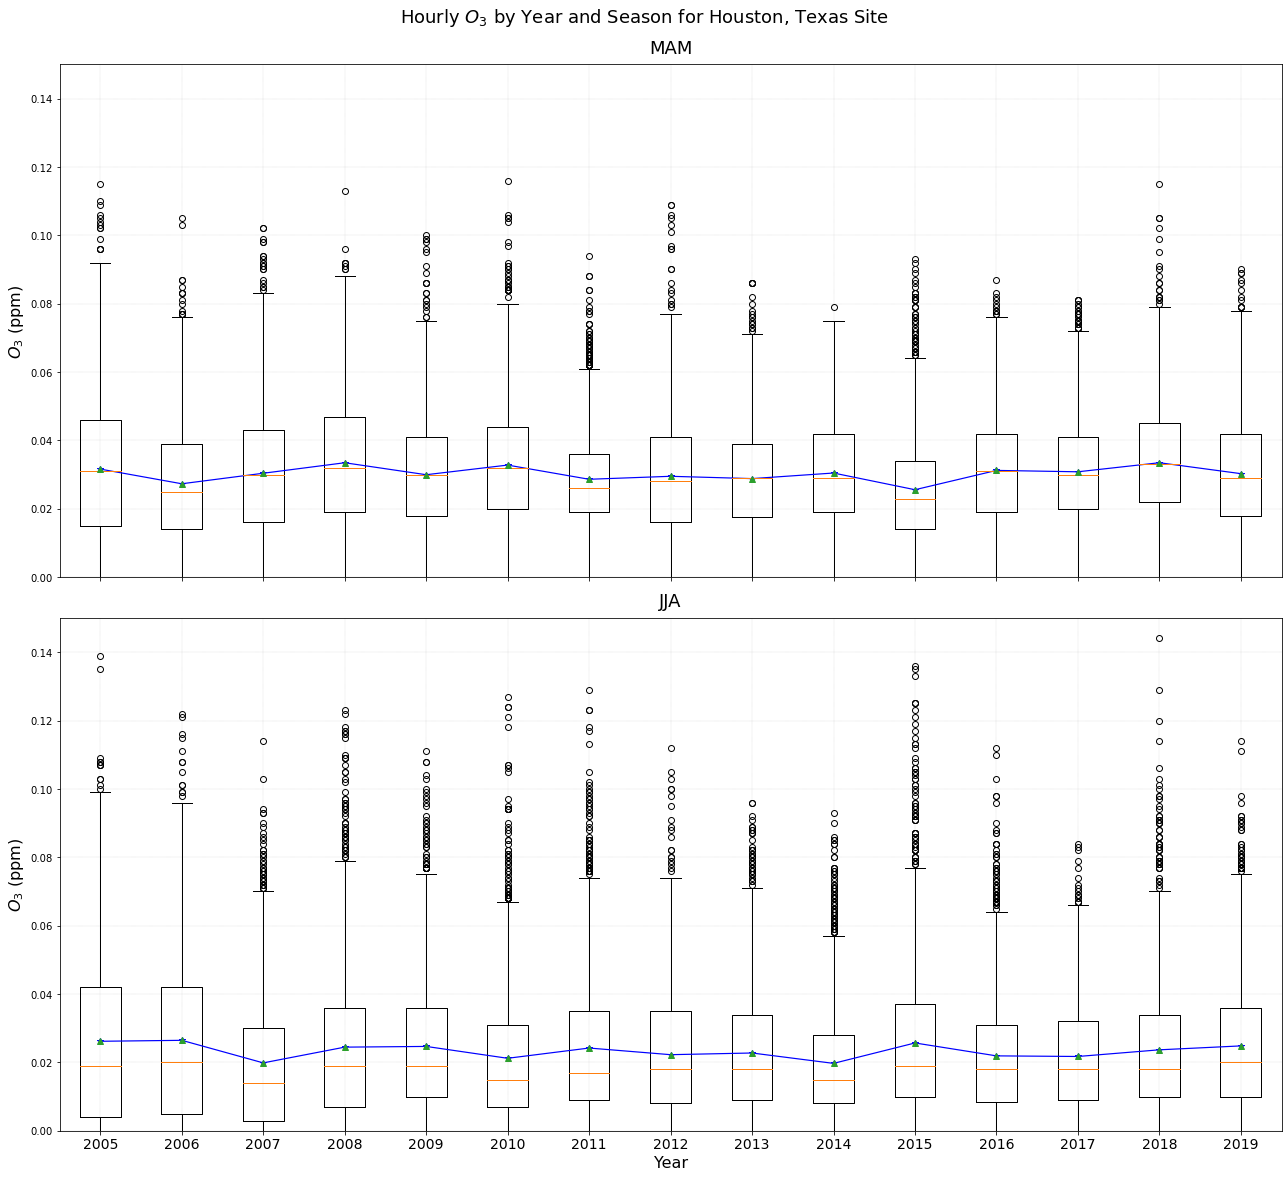

In [12]:
stat_mam = {}
stat_jja = {}
for yyyy in range(2005,2020):
    
    # Compute the boxplot stats (as in the default matplotlib implementation)
    stat_mam[yyyy] = cbook.boxplot_stats(((df_mam_year[pd.to_datetime(df_mam_year['Date Time Loc']).dt.year == yyyy]).iloc[:,1].to_numpy()))[0]
    stat_jja[yyyy] = cbook.boxplot_stats(((df_jja_year[pd.to_datetime(df_jja_year['Date Time Loc']).dt.year == yyyy]).iloc[:,1].to_numpy()))[0]
     
x_mam = np.vstack((np.arange(15), (np.array([stat_mam[x]['mean'] for x in stat_mam])))).T
xx_mam = x_mam[~np.isnan(x_mam).any(axis=1)]

x_jja = np.vstack((np.arange(15), (np.array([stat_jja[x]['mean'] for x in stat_jja])))).T
xx_jja = x_jja[~np.isnan(x_jja).any(axis=1)]

### FIgure plotting

fig, ax = plt.subplots(2, 1,figsize=(18,16))

### MAM
ax[0].bxp([stat_mam[n] for n in range(2005,2020)],positions=range(15),showmeans=True)
ax[0].plot(xx_mam[:,0], xx_mam[:,1],'b-*',linewidth=1.2)
ax[0].set_ylim(0, 0.15)
ax[0].set_xticks(np.arange(15))
ax[0].set_xticklabels([])
ax[0].set_ylabel('$O_3$ (ppm)',fontsize=16)
ax[0].set_title('MAM',y=1.01, fontsize=18)
ax[0].grid(linestyle='--', linewidth=0.2)

### JJA
ax[1].bxp([stat_jja[n] for n in range(2005,2020)],positions=range(15),showmeans=True)
ax[1].plot(xx_jja[:,0], xx_jja[:,1],'b-*',linewidth=1.2)
ax[1].set_ylim(0, 0.15)
ax[1].set_xticks(np.arange(15))
ax[1].set_xticklabels((list(np.arange(2005,2020))),rotation = 0,fontsize=14)
ax[1].set_ylabel('$O_3$ (ppm)',fontsize=16)
ax[1].set_xlabel('Year',fontsize=16)
ax[1].set_title('JJA',y=1.01, fontsize=18)
ax[1].grid(linestyle='--', linewidth=0.2)

plt.suptitle('Hourly $O_3$ by Year and Season for Houston, Texas Site',y=1.02, fontsize=18)
plt.tight_layout()
plt.savefig('./output/fig_05_mam_jja_hourly_boxplot.png',dpi=100,bbox_inches='tight')
plt.show()

### Trend analysis of yearly percentiles of ozone for MAM and JJA

In [13]:
array_result_mam = np.empty((9,0))
array_result_jja = np.empty((9,0))
np_array = np.empty((9,0))
np_array[:] = np.nan

for yyyy in range(2005,2020):
    ozone_data_mam = (df_mam_year[pd.to_datetime(df_mam_year['Date Time Loc']).dt.year == yyyy]).iloc[:,1].to_numpy()
    ozone_data_jja = (df_jja_year[pd.to_datetime(df_jja_year['Date Time Loc']).dt.year == yyyy]).iloc[:,1].to_numpy()
    
    array_result_mam = np.append(array_result_mam, (np.percentile(ozone_data_mam, [1,5,10,25,50,75,90,95,99]).reshape((9, 1))), axis=1)
    array_result_jja = np.append(array_result_jja, (np.percentile(ozone_data_jja, [1,5,10,25,50,75,90,95,99]).reshape((9, 1))), axis=1)
    
years_ava_mod = (np.arange(2005,2020)).reshape((15, 1)).astype(int)   

df_percentile_mam = pd.DataFrame(data = (np.append(years_ava_mod,array_result_mam.T, axis=1)))
df_percentile_jja = pd.DataFrame(data = (np.append(years_ava_mod,array_result_jja.T, axis=1)))

df_percentile_mam.columns = ['years']+[f'{i}%' for i in (np.array([1,5,10,25,50,75,90,95,99]))]
df_percentile_jja.columns = ['years']+[f'{i}%' for i in (np.array([1,5,10,25,50,75,90,95,99]))]

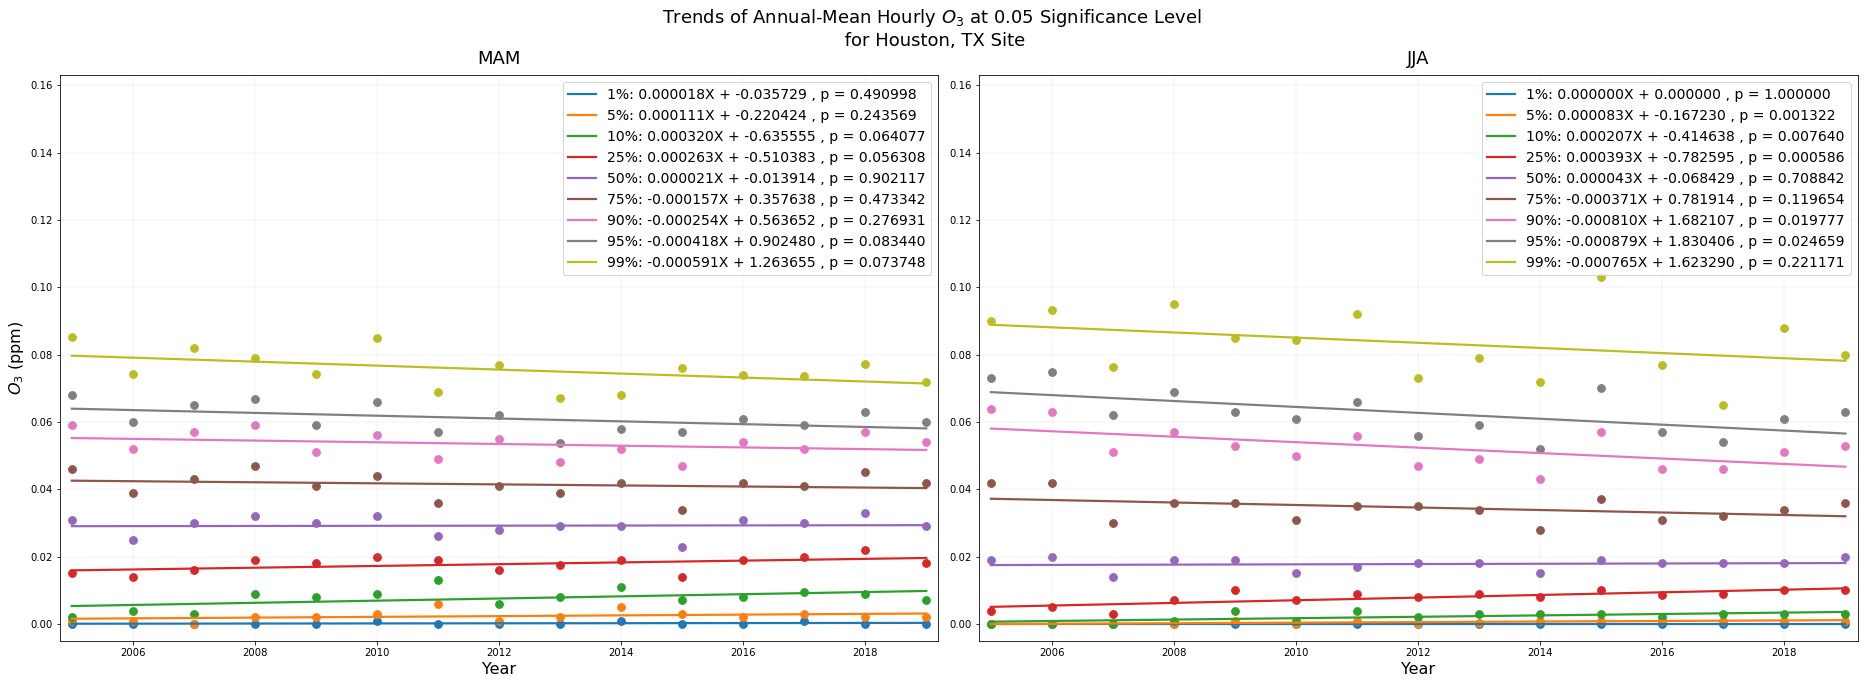

In [14]:
fig, ax = plt.subplots(1, 2,figsize=(26,9))

label_text_mam_com = []
label_text_jja_com = []

for i in range(1,10):
    
    slope_mam, intercept_mam, r_value_mam, p_value_mam, std_err_mam = stats.linregress(np.arange(2005,2020),(df_percentile_mam.iloc[:,i].to_numpy()))
    slope_jja, intercept_jja, r_value_jja, p_value_jja, std_err_jja = stats.linregress(np.arange(2005,2020),(df_percentile_jja.iloc[:,i].to_numpy()))
   
    m_mam = slope_mam.astype(float)
    m_jja = slope_jja.astype(float)
    
    # Add a regression line
    ax[0].scatter(np.arange(2005,2020), (df_percentile_mam.iloc[:,i].to_numpy()),s = 60)
    ax[0].plot((np.arange(2005,2020)), (m_mam*(np.arange(2005,2020)) + intercept_mam), linewidth=2.2)
    
    ax[1].scatter(np.arange(2005,2020), (df_percentile_jja.iloc[:,i].to_numpy()),s = 60)
    ax[1].plot((np.arange(2005,2020)), (m_jja*(np.arange(2005,2020)) + intercept_jja), linewidth=2.2)
    
    label_text_mam = df_percentile_mam.columns[i] + ': ' + f"{'%.6f'%slope_mam}X + {'%.6f'%intercept_mam} , p = {'%.6f'%p_value_mam}"
    label_text_jja = df_percentile_jja.columns[i] + ': ' + f"{'%.6f'%slope_jja}X + {'%.6f'%intercept_jja} , p = {'%.6f'%p_value_jja}"
    label_text_mam_com.append(label_text_mam)
    label_text_jja_com.append(label_text_jja)
     
ax[0].set_ylim(-0.005, 0.163) 
ax[0].set_xlim(2004.8, 2019.2)
ax[0].set_ylabel('$O_3$ (ppm)',fontsize=16)
ax[0].set_xlabel('Year',fontsize=16)
ax[0].set_title('MAM',y=1.01, fontsize=18)
ax[0].legend(label_text_mam_com,loc='best',fontsize=14)
ax[0].grid(linestyle='--', linewidth=0.2)

ax[1].set_ylim(-0.005, 0.163) 
ax[1].set_xlim(2004.8, 2019.2)
ax[1].set_xlabel('Year',fontsize=16)
ax[1].set_title('JJA',y=1.01, fontsize=18)
ax[1].legend(label_text_jja_com,loc='best',fontsize=14)
ax[1].grid(linestyle='--', linewidth=0.2)

plt.suptitle('Trends of Annual-Mean Hourly $O_3$ at 0.05 Significance Level \n for Houston, TX Site',y=1.05, fontsize=18)
plt.tight_layout()
plt.savefig('./output/fig_06_mam_jja_hourly_trend_percentile.png',dpi=100,bbox_inches='tight')
plt.show()